## Visualizing Video Embeddings with Feluda and t-SNE 
This notebook demonstrates how to use the [`feluda`](https://github.com/tattle-made/feluda) to extract video embeddings and visualize them using t-SNE, with thumbnails overlaid for each video. It includes:
- Setting up Feluda and its operators from an YAML config file.
- Using video data from a subset of the [UCF101 video dataset](https://huggingface.co/datasets/sayakpaul/ucf101-subset) dataset. We are using this for demo, but can be replaced with any video dataset.
- Generating video embeddings using feluda CLIP [video operator](https://pypi.org/project/feluda-vid-vec-rep-clip/).
- Reducing embedding dimensions using t-SNE
- Visualizing the reduced embeddings with video thumbnails

### Install Required Packages
Install dependencies conditionally based on whether the notebook is running in Colab or locally.

In [ ]:
%%time
import sys

IN_COLAB = "google.colab" in sys.modules
print("Running Notebook in Google Colab" if IN_COLAB else "Running Notebook locally")

if IN_COLAB:
    # Since Google Colab has preinstalled libraries like tensorflow and numba, we create a folder called feluda_custom_venv and isolate the environment there.
    # This is done to avoid any conflicts with the preinstalled libraries.
    !pip install uv
    !mkdir -p /content/feluda_custom_venv
    !uv pip install --target=/content/feluda_custom_venv --prerelease allow feluda feluda-vid-vec-rep-clip feluda-dimension-reduction opencv-python matplotlib > /dev/null 2>&1

    sys.path.insert(0, "/content/feluda_custom_venv")
else:
    !uv pip install feluda feluda-vid-vec-rep-clip feluda-dimension-reduction opencv-python matplotlib > /dev/null 2>&1

Running Notebook locally
Using Python 3.10.12 environment at: /home/aatman/Aatman/Tattle/feluda/.venv
Audited 5 packages in 9ms
CPU times: user 5.31 ms, sys: 4.17 ms, total: 9.48 ms
Wall time: 132 ms


In [2]:
import os
import sys
import tarfile
import tempfile
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import yaml
from huggingface_hub import hf_hub_download
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from tqdm.notebook import tqdm

from feluda import Feluda
from feluda.models.media_factory import VideoFactory

### Initializing Feluda class with config file

We'll use two operators for this example. One for extracting embeddings and other for dimension reduction.

In [3]:
# Instead of loading from a file, we'll define the configuration directly in code
def create_feluda_config():
    """Create and return a configuration dictionary for Feluda"""
    config = {
        "operators": {
            "label": "Operators",
            "parameters": [
                {
                    "name": "Dimension Reduction",
                    "type": "dimension_reduction",
                    "parameters": {"index_name": "video"},
                },
                {
                    "name": "Video Vector Representation",
                    "type": "vid_vec_rep_clip",
                    "parameters": {"index_name": "video"},
                },
            ],
        }
    }

    # Create a temporary file to store the configuration
    fd, config_path = tempfile.mkstemp(suffix=".yml")
    with open(fd, "w") as f:
        yaml.dump(config, f)

    return config_path


config_path = create_feluda_config()
print(f"Config created at {config_path}")

Config created at /tmp/tmpaviebdqb.yml


In [4]:
# Initialize Feluda and the operators
feluda = Feluda(config_path)
feluda.setup()

dimension_reduction_operator = feluda.operators.get()["dimension_reduction"]
vid_vec_clip_operator = feluda.operators.get()["vid_vec_rep_clip"]

t-SNE model successfully initialized
Installing packages for vid_vec_rep_clip


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


### Data Preparation

In [5]:
# Download and extract the UCF101 subset dataset
def download_and_extract_dataset():
    """Download and extract the UCF101 subset dataset from Hugging Face"""
    if not os.path.exists("UCF101_subset"):
        file_path = hf_hub_download(
            repo_id="sayakpaul/ucf101-subset",
            filename="UCF101_subset.tar.gz",
            repo_type="dataset",
        )

        with tarfile.open(file_path) as t:
            t.extractall(".")

        return file_path
    return None


file_path = download_and_extract_dataset()
print(f"Dataset downloaded at {file_path}")

Dataset downloaded at /home/aatman/.cache/huggingface/hub/datasets--sayakpaul--ucf101-subset/snapshots/b9984b8d2a95e4a1879e1b071e9433858d0bc24a/UCF101_subset.tar.gz


In [6]:
# Create thumbnails directory
thumbnail_dir = Path("thumbnails")
thumbnail_dir.mkdir(exist_ok=True)

In [7]:
def get_video_thumbnail(video_path):
    """Extract and save thumbnail from video.

    Args:
        video_path: Path to the video file

    Returns:
        Path to the saved thumbnail image
    """
    thumbnail_path = thumbnail_dir / f"{Path(video_path).stem}_thumbnail.jpg"

    # Return existing thumbnail if available
    if thumbnail_path.exists():
        return str(thumbnail_path)

    # Read the first frame from video
    cap = cv2.VideoCapture(str(video_path))
    ret, frame = cap.read()
    cap.release()

    if ret:
        cv2.imwrite(str(thumbnail_path), frame)
        return str(thumbnail_path)
    return None

In [8]:
def get_all_video_paths(base_dir="UCF101_subset"):
    """Get all video paths recursively from the dataset directory.

    Args:
        base_dir: Base directory containing videos

    Returns:
        List of video file paths
    """
    video_paths = []
    for path in Path(base_dir).rglob("*.avi"):
        video_paths.append(str(path))
    return video_paths


# Get all video paths
video_paths = get_all_video_paths()
print(f"Found {len(video_paths)} videos to process")

Found 405 videos to process


### Video Processing and Embedding Extraction

In [9]:
# Process videos and collect embeddings
def process_videos(video_paths, vid_vec_operator):
    """Process videos and extract embeddings using Feluda.

    Args:
        video_paths: List of paths to video files
        vid_vec_operator: Feluda operator for extracting video embeddings

    Returns:
        List of dictionaries containing video path, embedding, and thumbnail path
    """
    operator_parameters = []

    for video_path in tqdm(video_paths, desc="Processing videos"):
        try:
            # Get video thumbnail
            thumbnail_path = get_video_thumbnail(video_path)

            # Get video embedding
            video = VideoFactory.make_from_file_on_disk(video_path)
            embedding = vid_vec_operator.run(video)
            average_vector = next(embedding)

            operator_parameters.append(
                {
                    "payload": video_path,
                    "embedding": average_vector.get("vid_vec"),
                    "thumbnail_path": thumbnail_path,
                }
            )
        except Exception as e:
            print(f"Error processing {video_path}: {e}")
            continue

    print(f"Successfully processed {len(operator_parameters)} videos")
    return operator_parameters

In [10]:
%%time
# Process the videos
operator_parameters = process_videos(video_paths, vid_vec_clip_operator)
print(f"Successfully processed {len(operator_parameters)} videos")

Processing videos:   0%|          | 0/405 [00:00<?, ?it/s]

Successfully processed 405 videos
Successfully processed 405 videos
CPU times: user 6min 20s, sys: 1.02 s, total: 6min 22s
Wall time: 2min 43s


### Dimensionality Reduction and Visualization

In [11]:
# Reduce dimensions using operator for plotting t-SNE embeddings
data = dimension_reduction_operator.run(operator_parameters)

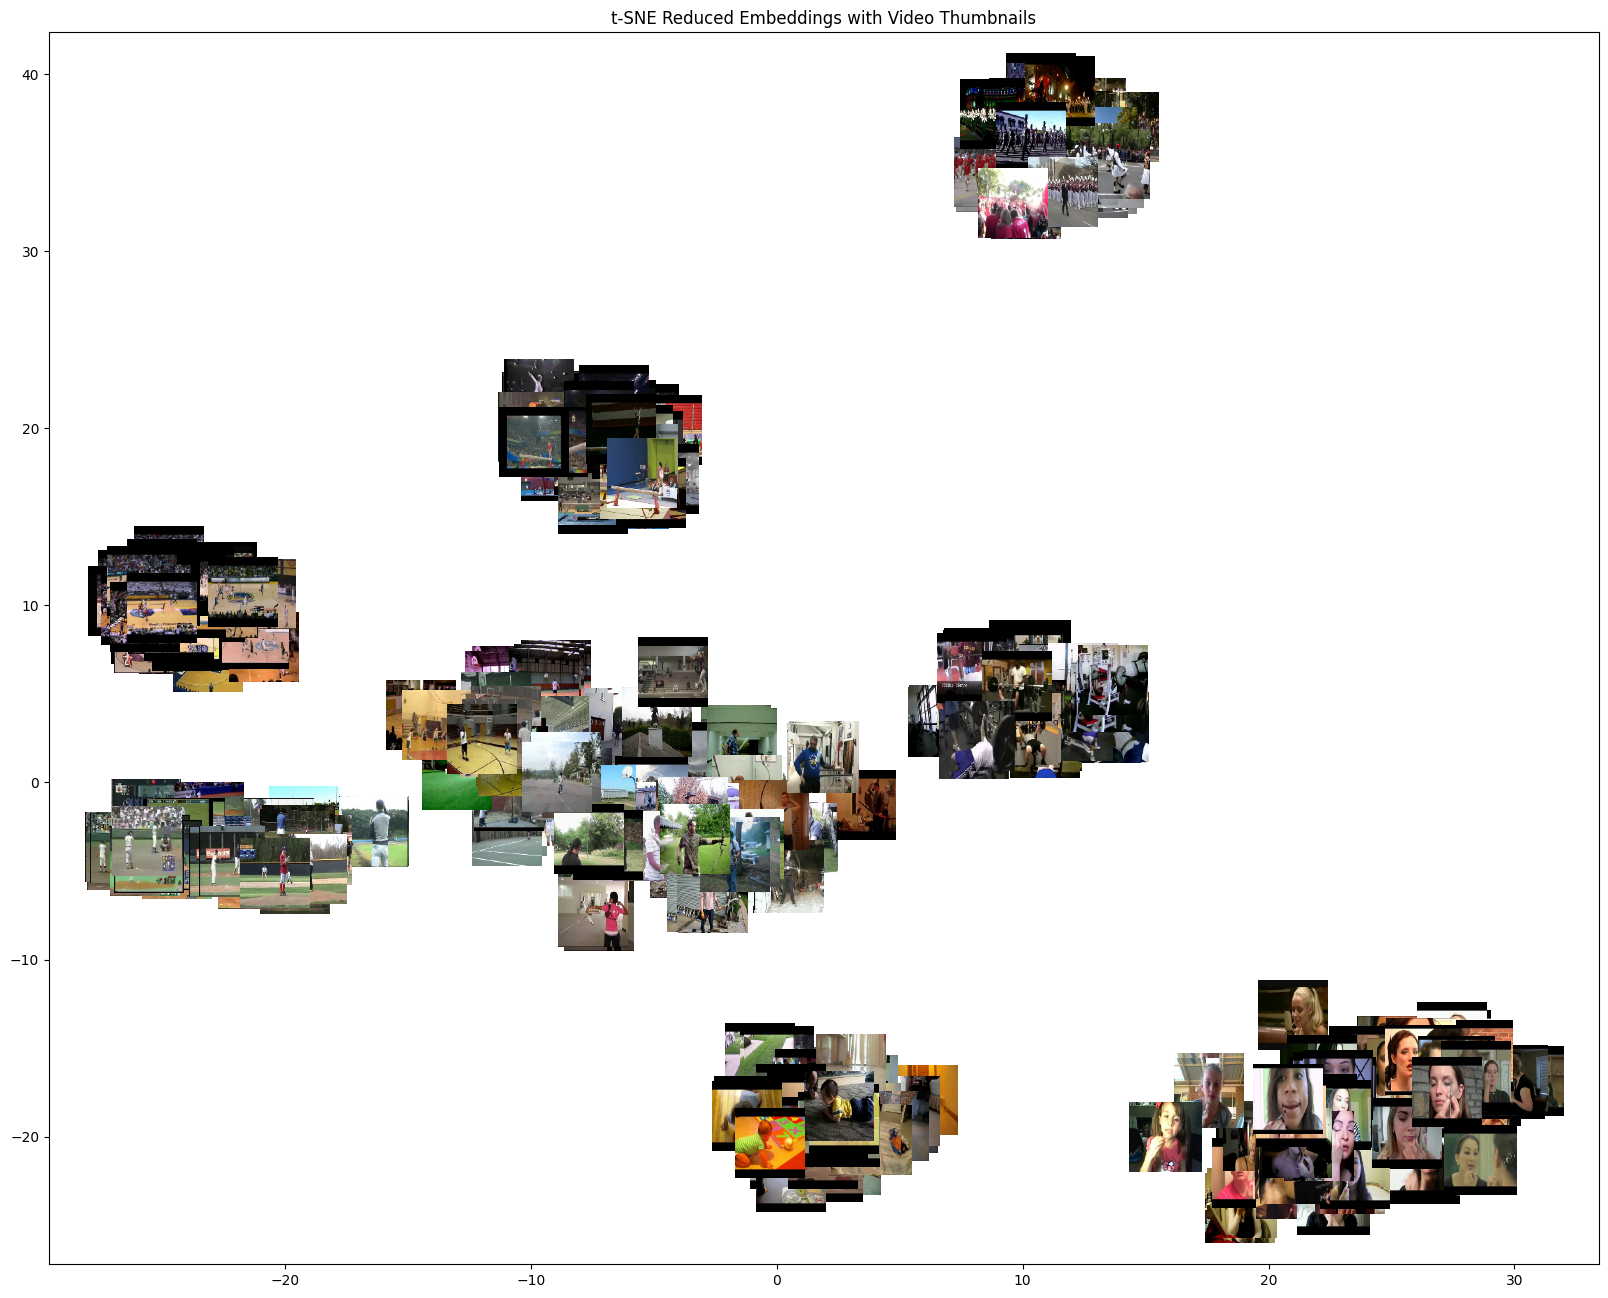

In [12]:
x = np.array([item["reduced_embedding"][0] for item in data])
y = np.array([item["reduced_embedding"][1] for item in data])


def jitter(arr, jitter_amount=0.02):
    return arr + np.random.uniform(-jitter_amount, jitter_amount, arr.shape)


x_jittered = jitter(x, jitter_amount=0.3)
y_jittered = jitter(y, jitter_amount=0.3)

plt.figure(figsize=(20, 16))
plt.scatter(x_jittered, y_jittered)


def load_thumbnail(payload):
    """Load the thumbnail from the pre-saved thumbnail folder."""
    video_filename = os.path.basename(payload)
    thumbnail_filename = video_filename.replace(".avi", "_thumbnail.jpg")
    thumbnail_path = os.path.join(thumbnail_dir, thumbnail_filename)

    if os.path.exists(thumbnail_path):
        return cv2.imread(thumbnail_path)
    else:
        print(f"Thumbnail not found for {video_filename}")
    return None


for i, item in enumerate(data):
    video_thumbnail = load_thumbnail(item["payload"])

    if video_thumbnail is not None:
        video_thumbnail = cv2.resize(video_thumbnail, (100, 100))  # Smaller thumbnails
        video_thumbnail = cv2.cvtColor(video_thumbnail, cv2.COLOR_BGR2RGB)

        # Keep zoom as is, no need for offsets anymore
        imagebox = OffsetImage(video_thumbnail, zoom=0.5)
        ab = AnnotationBbox(
            imagebox, (x_jittered[i], y_jittered[i]), frameon=False
        )  # Use jittered values

        plt.gca().add_artist(ab)

# Set labels and title
plt.title("t-SNE Reduced Embeddings with Video Thumbnails")
plt.show()

### Cleanup Temporary Files

In [13]:
import shutil

shutil.rmtree("thumbnails")
shutil.rmtree("UCF101_subset")
if file_path:
    os.remove(file_path)
os.remove(config_path)
print("Cleaned up temporary files.")

Cleaned up temporary files.
